# Packages & Includes

In [ ]:
using Plots
using StatsBase
using LinearAlgebra
#using Statistics
using JLD2
using StaticArrays

# data structs
include("SpinEnsemble.jl");
include("EchoParams.jl");

# function libraries
include("gen_spins.jl");
include("spin_sims.jl");

include("liouville_tools.jl");


# Parameters

In [47]:
# spin variables and operators
Ix = @SMatrix [0 1/2; 1/2 0];
Iy = @SMatrix [0 -1im/2; 1im/2 0];
Iz = @SMatrix [1/2 0; 0 -1/2];
M_op = Ix+1im*Iy;

# magnetic/frequency variables
γ = 2*pi*1e6; # gyromagnetic ratio

# coupling mode variables
#α_list = collect(LinRange(0,0.2,9));
α = 0.2;
ω = 0.001; # 1 kHz

# frequency distribution variables
ν0 = 10; # central frequency, 10 MHz
#base_num_freq = 200; # frequency is given by base_num_freq*num_list[i] (looped over i)
#num_list = [1,2,3]
num_freq = 300; # number of spins
bandwidth = 1.0; # bandwidth of dist.
integration_samp = true # true: weighted sampling, false: finite sampling
dist_type = 1 # 0: Gaussian/Normal, 1: Lorentzian/Cauchy

# τ and timing parameters
time_scale = γ;
τ = 100e-6; # time unit
dt = 1; # time spacing
nτ = convert(Int64, round(τ*time_scale/dt)); # probably don't need to round?
t = convert(Array, LinRange(0, 3*τ*1e6, 3*nτ)) # timing list (should probably return from calcs instead)

# for saving the data
#nM = 3*nτ;
#M_list = zeros(Complex{Float64}, nM, size(α_list,1), size(num_list,1));

# initial density matrix
dim = 2;
ψ_0 = @SArray [1 0];
ρ_temp = [0 0; 0 0];
for i = 1:dim
    for j = 1:dim
        ρ_temp[i,j] = ψ_0[i]*ψ_0[j];
    end
end
ρ_0 = @SMatrix [ρ_temp[1,1] ρ_temp[1,2];
                ρ_temp[2,1] ρ_temp[2,2]];

# pulse operators
UL90 = exp(-1im*pi*Ix/2);
UR90 = exp(1im*pi*Ix/2);

# Simulation loop

In [48]:
params = EchoParams(dt, nτ, ω, α, M_op, Iz, UL90, UR90)

gam_list = exp10.(collect(LinRange(-4,-2,5)))
pushfirst!(gam_list,0)
M_save = zeros(Complex{Float64},3*params.nτ,size(gam_list,1))

for g = 1:size(gam_list,1)
    println(g,"/",size(gam_list,1))
    gam_0 = 1.0*gam_list[g]
    gam_1 = gam_0
    gam_2 = gam_0
    gam_3 = 0.0*gam_list[g]

    nJ = 3
    Lj_list = zeros(nJ,2,2)
    Lj_list[1,:,:] = sqrt(gam_1)*[0 1; 0 0]
    Lj_list[2,:,:] = sqrt(gam_2)*[0 0; 1 0]
    Lj_list[3,:,:] = sqrt(gam_3)*Iz
    params.Lj_list = Lj_list

    ν_list, P_list = gen_spins(ν0, num_freq,integration_samp,dist_type,bandwidth);
    ρ_init = [ρ_0 for j = 1:size(P_list,1)];
    spins = SpinEnsemble(ν0, P_list, ν_list, ρ_init)
    # run the evolution
    M_save[:,g] = spin_echo_sim_liouville(spins,params);
end


1/6
2/6
3/6
4/6
5/6
6/6


# Plotting

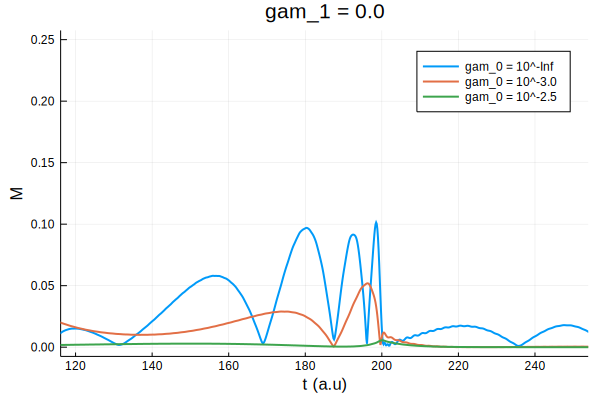

In [54]:
plt1 = plot()
for g = [1,4,5]#1:size(gam_list,1)
    plot!(t,broadcast(abs,M_save[:,g]),lw=2,label=string("gam_0 = 10^",log10(gam_list[g])),
            xlabel = "t (a.u)", ylabel = "M",title="gam_1 = 0.0")
    yaxis!([0,0.25])
    xaxis!([120, 250])
end
display(plt1)
savefig(plt1,"imgs/dissipative_echo_alpha0p20_no_gam1.png")

# Propagation only test (no pulses)

In [132]:
params = EchoParams(dt, nτ, ω, α, M_op, Iz, UL90, UR90)
params.M_op = Iz
params.α = 0.01
params.dt = 5.0
params.nτ = 4000

bandwidth = 0.5;

num_freq = 5;
ν_list, P_list = gen_spins(ν0, num_freq,integration_samp,dist_type,bandwidth);
ρ_init = [ρ_0 for j = 1:size(P_list,1)];
spins = SpinEnsemble(ν0, P_list, ν_list, ρ_init)


gam_list = exp10.(collect(LinRange(-6,-4,5)))
pushfirst!(gam_list,0)
M_save = zeros(Complex{Float64},params.nτ,size(gam_list,1))

for g = 1:size(gam_list,1)
    println(g,"/",size(gam_list,1))
    gam_0 = gam_list[g]
    gam_1 = gam_0
    gam_2 = gam_0
    gam_3 = 0.0*gam_0_list[g]

    nJ = 3
    Lj_list = zeros(nJ,2,2)
    Lj_list[1,:,:] = sqrt(gam_1)*[0 1; 0 0]
    Lj_list[2,:,:] = sqrt(gam_2)*[0 0; 1 0]
    Lj_list[3,:,:] = sqrt(gam_3)*Iz
    params.Lj_list = Lj_list
    
    # initialize M_list
    M_list = []
    # 90 pulse
    # ρ_init_L = [dm_H2L(UL90*ρ*UR90) for ρ in spins.ρ_init]
    ρ_init_L = [dm_H2L(ρ) for ρ in spins.ρ_init]

    # first tau
    t0 = 0.0

    #exp(JumpToSuper(Lj_list[1,:,:]) - 1im*HamToSuper(Iz))
    ρ_list, M, t = time_propagate_liouville(ρ_init_L, M_list, t0, params.dt, params.nτ, spins, params);
    M_save[:,g] = M
end
    

1/6
2/6
3/6
4/6
5/6
6/6


# Plot simple propagation test

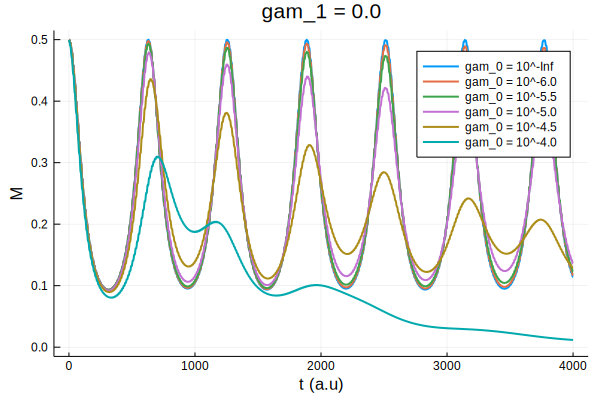

In [133]:
plt1 = plot()
for g = 1:size(gam_list,1)
    plot!(broadcast(abs,M_save[:,g]),lw=2,label=string("gam_0 = 10^",log10(gam_list[g])),
            xlabel = "t (a.u)", ylabel = "M",title="gam_1 = 0.0")
    yaxis!([0,0.5])
end
display(plt1)
#savefig(plt1,"imgs/dissipation_test_no_gam1.png")